## Detecting Network Attacks With Isolation Forests
[Good source](https://www.depends-on-the-definition.com/detecting-network-attacks-with-isolation-forests/) for Isolation Forest

## Dataset
 - 1998 DARPA off-line Intrusion Detection System dataset, created by MIT Lincoln Lab in 1999.
 
 [link to dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_kddcup99.html#sklearn.datasets.fetch_kddcup99)

In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import datetime

%matplotlib inline

## Load datasets

In [24]:
cols = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

In [25]:
df = pd.read_csv("kddcup.data_10_percent_corrected", sep =",", names=cols + ["label"], index_col=None)

In [26]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
cols.remove("service")
df.shape

(64293, 41)

In [8]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,SF,181,5450,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,SF,239,486,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,SF,235,1337,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,SF,219,1337,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,SF,217,2032,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [9]:
df.label.value_counts()

normal.       61886
back.          2203
neptune.        192
phf.              4
ipsweep.          3
portsweep.        3
satan.            2
Name: label, dtype: int64

## Data Processing Stage

In [10]:
from sklearn.preprocessing import LabelEncoder

encs = dict()
data = df.copy()  #.sample(frac=1)
for c in data.columns:
    if data[c].dtype == "object":
        encs[c] = LabelEncoder()
        data[c] = encs[c].fit_transform(data[c])

In [11]:
data.shape

(64293, 41)

## Train Isolation Forest and Local Outlier Factor in Supervised Setting

In [12]:
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(data.drop(['label'], axis=1),data['label'], 
                                                    test_size=0.33, random_state=11)

In [13]:
iForest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.05, random_state=2018)

In [14]:
iForest.fit(X_train_sa)

IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples=256, n_estimators=100, n_jobs=1, random_state=2018,
        verbose=0)

In [15]:
scores = iForest.decision_function(X_test_sa)

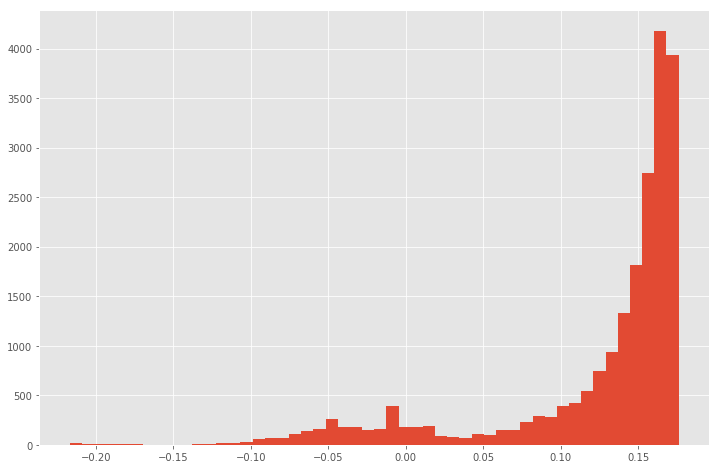

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50);

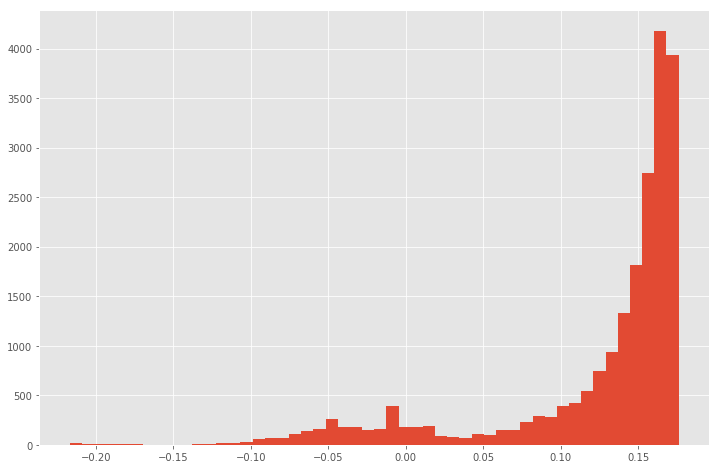

In [17]:
iForest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.5, random_state=2018)
iForest.fit(X_train_sa)
scores = iForest.decision_function(X_test_sa)
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50);

## Results

In [18]:
encs["label"].classes_

array(['back.', 'ipsweep.', 'neptune.', 'normal.', 'phf.', 'portsweep.',
       'satan.'], dtype=object)

In [19]:
normal_label = list(encs["label"].classes_).index("normal.")
normal_label

3

In [20]:
y_test_sa.value_counts()

3    20458
0      689
2       65
4        3
6        1
1        1
Name: label, dtype: int64

In [21]:
from sklearn.metrics import roc_auc_score

print("AUC: {:.1%}".format(roc_auc_score((-0.1 < scores), y_test_sa == normal_label)))

AUC: 75.5%


In [22]:
contamination_vals = np.arange(-0.2, 0.05, 0.01)
AUCs = [roc_auc_score(c < scores, y_test_sa == normal_label) for c in contamination_vals]

Text(0.5,1,'Best Score Threshold -0.16 >> AUC 0.98 ')

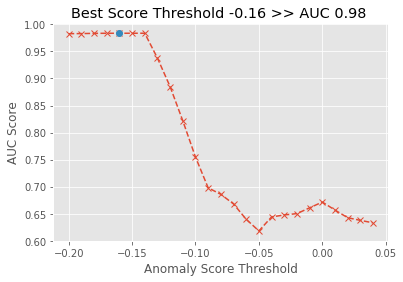

In [23]:
best = np.argmax(AUCs)
plt.plot(contamination_vals, AUCs, "--x")
plt.xlabel('Anomaly Score Threshold'); plt.ylabel('AUC Score')
plt.plot(contamination_vals[best], AUCs[best], 'o')
plt.title("Best Score Threshold {} >> AUC {} ".format(np.round(contamination_vals[best], 2), 
                                                      np.round(AUCs[best],2)))